In [1]:
from Data import AnnaDataset, InvertAnna, IntcodeAnna
from Models import BRNN
from Utils.HelperFunctions import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import gc
import os
%matplotlib inline  
# use gpu when possible
mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(mydevice)

cuda:0


In [2]:
# parameters
BATCH_SIZE = 512
N_STEPS = 10
N_HIDDEN = 512
N_PART = 2
K = 5 
N_LAYERS = 2
N_EPOCHS = 51
learning_rates = np.asarray([2e-5,1e-5,2e-5,1e-5])
lr_ratio =  np.asarray([1,1,1e-1,1e-1]) # relative speed of hyper to base parameter optimization
clip = 5
N_REPS = len(learning_rates)

# data set split (consider moving into the AnaDataset instead)
dataset = AnnaDataset(N_STEPS)
n = len(dataset)  # how many total elements you have
n_test = int( n * .1 )  # number of test/val elements
n_train = n - 2 * n_test
idx = list(range(n))  # indices to all elements
np.random.shuffle(idx)  # in-place shuffle the indices to facilitate random splitting
train_idx = idx[:n_train]
val_idx = idx[n_train:(n_train + n_test)]
test_idx = idx[(n_train + n_test):]

train_set = torch.utils.data.Subset(dataset, train_idx)
val_set = torch.utils.data.Subset(dataset, val_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)
validation_loader = DataLoader(val_set, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

N_INPUTS = len(dataset.categories)
N_OUTPUTS = N_INPUTS

In [3]:
train_loss = np.zeros((N_EPOCHS,N_REPS))
train_acc = np.zeros((N_EPOCHS,N_REPS))
test_loss = np.zeros((N_EPOCHS,N_REPS))
test_acc = np.zeros((N_EPOCHS,N_REPS))

dummy_model = BRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,N_PART,K,mydevice)
lambda_hist = np.zeros((len(dummy_model.regularize.weight.data.flatten()),N_EPOCHS+1,N_REPS))
del(dummy_model)

model = [None]*N_REPS
for rep in tnrange(N_REPS):
    model_path = r'D:\chongguo\git\MLClubModelZoo\PRNN\final_project\History\model_lr{}_lr_ratio{}.pt'.format(int(learning_rates[rep]*1e6),int(lr_ratio[rep]*10))
    model[rep] = BRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,N_PART,K,mydevice)
    optimizer_base = torch.optim.RMSprop(model[rep].parameters(), lr=learning_rates[rep], momentum=0.9)
    criterion_base = nn.CrossEntropyLoss()
    optimizer_super = torch.optim.RMSprop(model[rep].parameters(), lr=lr_ratio[rep]*learning_rates[rep], momentum=0.9)
    criterion_super = nn.CrossEntropyLoss()
    lambda_hist[:,0,rep] = model[rep].regularize.weight.data.flatten().cpu().numpy()
    for epoch in tnrange(N_EPOCHS):
        running_train_loss = 0
        running_train_acc = 0
        running_test_loss = 0
        running_test_acc = 0
        # train
        model[rep].train()
        for i, (train_data, val_data) in enumerate(zip(train_loader,cycle(validation_loader))):
            x_train, y_train = train_data
            x_val, y_val = val_data
            # calculate loss on training dataset
            model[rep].zero_grad()
            x_train, y_train = x_train.to(mydevice), y_train.to(mydevice)
            y_train_pred, hidden = model[rep](x_train)
            loss_base = criterion_base(y_train_pred[-1,:,:],y_train)
            # record performance on training dataset
            running_train_loss+=loss_base.item()
            running_train_acc+=get_accuracy(y_train_pred[-1,:,:], y_train)
            # step the base optimizer
            loss_base = loss_base + model[rep].block_norm()/BATCH_SIZE
            loss_base.backward()
            model[rep].regularize.weight.grad.data.zero_() # zero the gradient of the regularizer
            nn.utils.clip_grad_norm(model[rep].parameters(), clip) # clip gradient to prevent explosion
            optimizer_base.step()
            
            # caculate loss on validation dataset
            model[rep].zero_grad()
            x_val, y_val = x_val.to(mydevice), y_val.to(mydevice)
            y_val_pred, hidden = model[rep](x_val)
            loss_super = criterion_super(y_val_pred[-1,:,:],y_val)
            # step the hyperparameter optimizer
            loss_super = loss_super+model[rep].zero_regularize_grad()
            loss_super.backward()
            model[rep].hypergrad() # calculate gradient of hyperparameter ()
            optimizer_super.step()
            model[rep].reprojection()
            
        # update history 
        lambda_hist[:,epoch+1,rep] = model[rep].regularize.weight.data.flatten().cpu().numpy()
        train_loss[epoch,rep] = running_train_loss/(i+1)
        train_acc[epoch,rep] = running_train_acc/(i+1)
        
        # test
        model[rep].eval()
        for i, test_data in enumerate(test_loader):
            x_test, y_test = test_data
            x_test, y_test = x_test.to(mydevice), y_test.to(mydevice)
            y_test_pred, hidden = model[rep](x_test)
            loss = criterion_base(y_test_pred[-1,:,:],y_test)
            # record performance on validation dataset
            running_test_loss+=loss.item()
            running_test_acc+=get_accuracy(y_test_pred[-1,:,:], y_test)
            
        # update history 
        lambda_hist[:,epoch+1,rep] = model[rep].regularize.weight.data.flatten().cpu().numpy()
        train_loss[epoch,rep] = running_train_loss/(i+1)
        train_acc[epoch,rep] = running_train_acc/(i+1)
        test_loss[epoch,rep] = running_test_loss/(i+1)
        test_acc[epoch,rep] = running_test_acc/(i+1)
         
    torch.save(model[rep].state_dict(), model_path)
    if test_acc[-1,rep]>best_test_acc:
        bestmodel = model[rep]
        best_test_acc = test_acc[-1,rep]
    model[rep] = [None]

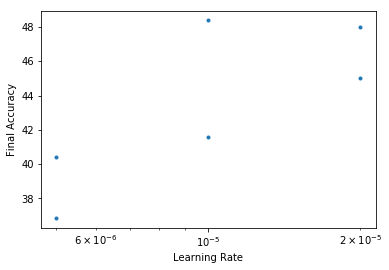

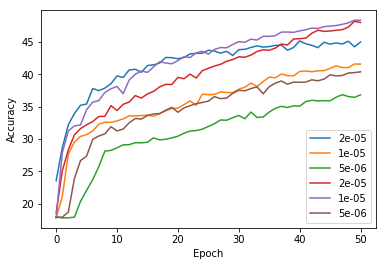

In [22]:
plt.plot(learning_rates[3:],test_acc[-1,3:],'.')
plt.xscale('log')
plt.ylabel('Final Accuracy')
plt.xlabel('Learning Rate')
plt.show()
plt.plot(test_acc[:,3:])
plt.legend(learning_rates[3:])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

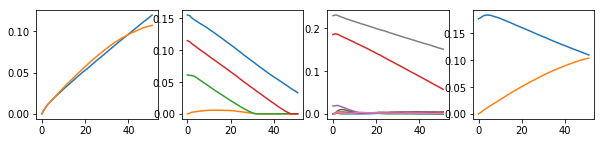

In [44]:
plt.figure(figsize=(10,2))
plt.subplot(1,4,1)
plt.plot(lambda_hist[:2,:,7].T)
plt.subplot(1,4,2)
plt.plot(lambda_hist[2:6,:,7].T)
plt.subplot(1,4,3)
plt.plot(lambda_hist[6:14,:,7].T)
plt.subplot(1,4,4)
plt.plot(lambda_hist[14:,:,7].T)
plt.show()

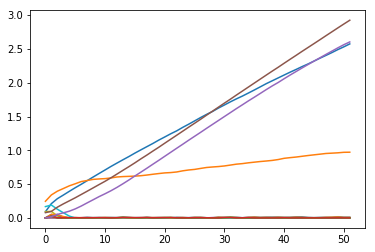

In [12]:
plt.plot(lambda_hist[:,:,3].T)
plt.show()

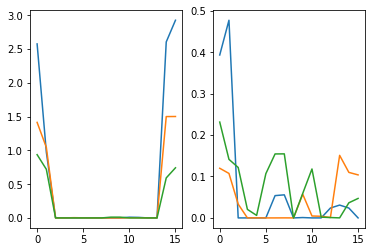

In [27]:
plt.subplot(1,2,1)
plt.plot(lambda_hist[:,-1,3:6])
plt.subplot(1,2,2)
plt.plot(lambda_hist[:,-1,6:])
plt.show()

In [28]:
model[-2]
model[-2].eval()
x, y_tar = next(iter(train_loader))
y_pred, hidden = model[-2](x.to(mydevice))
trial_samp = np.random.randint(x.shape[0])
print(''.join(InvertAnna(torch.max(x[trial_samp,1:,:],1)[1]))+InvertAnna(y_tar)[trial_samp])
print(''.join(InvertAnna(torch.max(y_pred[:,trial_samp,:].squeeze(),1)[1])))
plt.plot(np.arange(1,11),y_pred.permute(1,2,0).data.cpu().numpy()[trial_samp,:,:].T,'-')
plt.ylabel('Output')
plt.xlabel('time step')
plt.show()

AttributeError: 'list' object has no attribute 'eval'